These codelabs are largely based on scikit-learn example code.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Random Forest

The sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. Both algorithms are perturb-and-combine techniques specifically designed for trees. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

As other classifiers, forest classifiers have to be fitted with two arrays: a sparse or dense array X of size [n_samples, n_features] holding the training samples, and an array Y of size [n_samples] holding the target values (class labels) for the training samples:

In [2]:
from sklearn.ensemble import RandomForestClassifier
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)

In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

In contrast to the original publication, the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

print(clf.feature_importances_)
print(clf.predict([[0, 0, 0, 0]]))

[0.14205973 0.76664038 0.0282433  0.06305659]
[1]


## Exercise

Copy the SVM notebook and replace SVM with random forests.

## OOB Errors for Random Forests

The RandomForestClassifier is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations z_i = (x_i, y_i). The out-of-bag (OOB) error is the average error for each z_i calculated using predictions from the trees that do not contain z_i in their respective bootstrap sample. This allows the RandomForestClassifier to be fit and validated whilst being trained.

The example below demonstrates how the OOB error can be measured at the addition of each new tree during training. The resulting plot allows a practitioner to approximate a suitable value of n_estimators at which the error stabilizes.

Automatically created module for IPython interactive environment


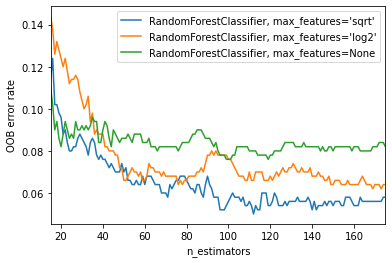

In [6]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Voting: RF compared to two other algorithms

Plot the class probabilities of the first sample in a toy dataset predicted by three different classifiers and averaged by the VotingClassifier.

First, three examplary classifiers are initialized (LogisticRegression, GaussianNB, and RandomForestClassifier) and used to initialize a soft-voting VotingClassifier with weights [1, 1, 5], which means that the predicted probabilities of the RandomForestClassifier count 5 times as much as the weights of the other classifiers when the averaged probability is calculated.

To visualize the probability weighting, we fit each classifier on the training set and plot the predicted class probabilities for the first sample in this example dataset.

Automatically created module for IPython interactive environment


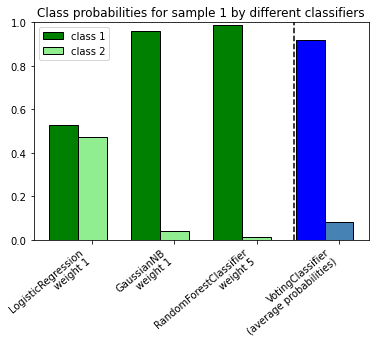

In [7]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=123)
clf2 = RandomForestClassifier(random_state=123)
clf3 = GaussianNB()
X = np.array([[-1.0, -1.0], [-1.2, -1.4], [-3.4, -2.2], [1.1, 1.2]])
y = np.array([1, 1, 2, 2])

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                        voting='soft',
                        weights=[1, 1, 5])

# predict class probabilities for all classifiers
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression\nweight 1',
                    'GaussianNB\nweight 1',
                    'RandomForestClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.show()


## Imputing missing values before building an estimator

Now we'll look at random forest regressors.

This example shows that imputing the missing values can give better results than discarding the samples containing any missing value. Imputing does not always improve the predictions, so please check via cross-validation. Sometimes dropping rows or using marker values is more effective.

Missing values can be replaced by the mean, the median or the most frequent value using the strategy hyper-parameter. The median is a more robust estimator for data with high magnitude variables which could dominate results (otherwise known as a ‘long tail’).

In this case, imputing helps the classifier get close to the original score (0.56 for the entire dataset, 0.48 without samples containing missing values, 0.55 after imputation of the missing values).

In [12]:
import numpy as np

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

rng = np.random.RandomState(0)

dataset = load_boston()
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

# Estimate the score on the entire dataset, with no missing values
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(estimator, X_full, y_full).mean()
print("Score with the entire dataset = %.2f" % score)

# Add missing values in 75% of the lines
missing_rate = 0.75
n_missing_samples = int(np.floor(n_samples * missing_rate))
missing_samples = np.hstack((np.zeros(n_samples - n_missing_samples,
                                      dtype=bool),
                             np.ones(n_missing_samples,
                                     dtype=bool)))
rng.shuffle(missing_samples)
missing_features = rng.randint(0, n_features, n_missing_samples)

# Estimate the score without the lines containing missing values
X_filtered = X_full[~missing_samples, :]
y_filtered = y_full[~missing_samples]
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(estimator, X_filtered, y_filtered).mean()
print("Score without the samples containing missing values = %.2f" % score)

# Estimate the score after imputation of the missing values
X_missing = X_full.copy()
X_missing[np.where(missing_samples)[0], missing_features] = 0
y_missing = y_full.copy()
estimator = Pipeline([("imputer", SimpleImputer(missing_values=0,
                                          strategy="mean")),
                      ("forest", RandomForestRegressor(random_state=0,
                                                       n_estimators=100))])
score = cross_val_score(estimator, X_missing, y_missing).mean()
print("Score after imputation of the missing values = %.2f" % score)


Score with the entire dataset = 0.62
Score without the samples containing missing values = 0.41
Score after imputation of the missing values = 0.60
